In [27]:
import numpy as np
import pandas as pd

The drive link for the datasets and trained models is "[Google Drive Link](https://drive.google.com/drive/folders/14Har_LxejVHaMf_sxMpqTThqUUR9CcSU?usp=drive_link)"

https://drive.google.com/drive/folders/14Har_LxejVHaMf_sxMpqTThqUUR9CcSU?usp=drive_link

In [28]:
dataset_dir = "../datasets"

train_file = 'news_traindata'
train_nrows = 110000 * 0.9
train_df = pd.read_csv(f'{dataset_dir}/{train_file}.csv', encoding='utf-8', nrows=train_nrows)
train_df = train_df.dropna()

test_file = 'news_testdata'
test_nrows = 110000 * 0.1
test_df = pd.read_csv(f'{dataset_dir}/{test_file}.csv', encoding='utf-8', nrows=test_nrows)
test_df = test_df.dropna()

vocab_file = f'vocabs/vokab_{train_file}_{train_nrows}.pkl'
model_file = f"models/primary_model_{train_file}_{train_nrows}.pth"
encoded_testfile = f"encoded/primary_{test_file}_{test_nrows}.pt"
encoded_trainfile = f"encoded/primary``_{train_file}_{train_nrows}.pt"


In [29]:
test_df.iloc[0]['content']

'9/11 Commissioners Admit They Never Got the Full Story\n\nThe 9/11 Commissioners publicly expressed anger at cover ups and obstructions of justice by the government into a real 9/11 investigation:\n\nThe 9/11 Commission chair said the Commission was “set up to fail”\n\nThe Commission’s co-chairs said that the CIA (and likely the White House) “obstructed our investigation”\n\n9/11 Commissioner Timothy Roemer said “We were extremely frustrated with the false statements we were getting”\n\nThe Senior Counsel to the 9/11 Commission (John Farmer) – who led the 9/11 staff’s inquiry – said “At some level of the government, at some point in time…there was an agreement not to tell the truth about what happened“. He also said “I was shocked at how different the truth was from the way it was described …. The tapes told a radically different story from what had been told to us and the public for two years…. This is not spin. This is not true.”\n\nNo wonder the Co-Chair of the congressional invest

In [30]:
train_df['content'] = train_df['title'].fillna('') + ' ' + train_df['content'].fillna('')
test_df['content'] = test_df['title'].fillna('') + ' ' + test_df['content'].fillna('')

In [31]:
import os
import pickle
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.utils import get_tokenizer
from collections import Counter

MAX_VOCAB = 50000
special_tokens = ['<unk>', '<pad>']
tokenizer = get_tokenizer('basic_english')


if os.path.exists(vocab_file):
    with open(vocab_file, 'rb') as f:
        vocab = pickle.load(f)
    print("Vocabulary loaded from 'vocab.pkl'.")

else:
    print("Vocab not found: ", vocab_file)

Vocabulary loaded from 'vocab.pkl'.


In [32]:

import torch
from torch.nn.utils.rnn import pad_sequence

MAX_LENGTH = 4096

def encode_text_primary_model(vocab, df, encoded_file):
    encoded_texts = []
    labels = []

    for text, label in zip(df['content'], df['label']):
        if pd.notna(text):
            encoded = [vocab[token] for token in tokenizer(text)]
            
            if len(encoded) <= MAX_LENGTH:  # Filter long sequences
                encoded_texts.append(torch.tensor(encoded, dtype=torch.long))
                labels.append(label)

    encoded_texts = pad_sequence(encoded_texts, batch_first=True, padding_value=vocab['<pad>'])
    labels = torch.tensor(labels, dtype=torch.float)


    return encoded_texts, labels

test_encoded_texts, test_labels = encode_text_primary_model(vocab, test_df, encoded_testfile)

In [33]:
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split


class NewsDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


val_ds = NewsDataset(test_encoded_texts, test_labels)
val_dl = DataLoader(val_ds, batch_size=32, num_workers=0)

In [34]:
from mulstage_model import CNN_BiLSTM
from torch import nn


# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(f"Using device: {device}")

model = CNN_BiLSTM(vocab=vocab, vocab_size=len(vocab), embed_dim=100, hidden_dim=128, output_dim=1, pad_idx=vocab['<pad>'])
model.to(device)


criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)   

model.load_state_dict(torch.load(model_file, map_location=device))

Using device: mps


<All keys matched successfully>

In [35]:
def evaluate(model, loader):
    model.eval()
    total_acc = 0

    preds_list = []
    actuals_list = []

    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            preds_class = (preds > 0.5).float()
            preds_list.append(preds_class.cpu().numpy())
            actuals_list.append(yb.cpu().numpy())
            total_acc += (preds_class == yb).float().mean().item()
    return total_acc / len(loader), preds_list, actuals_list

test_acc, preds_list, actuals_list = evaluate(model, val_dl)
print(f"Test accuracy: {test_acc:.4f}")

Test accuracy: 0.9863


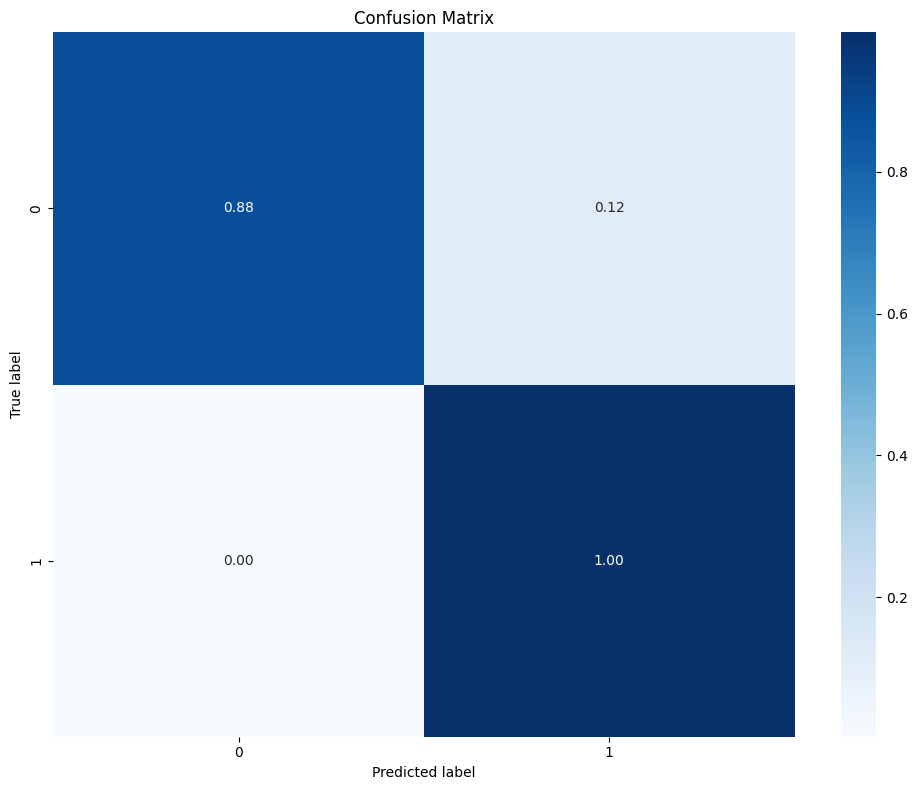

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, classes, normalize=False):
    # Ensure input is NumPy array
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    cm = confusion_matrix(y_true, y_pred, labels=classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1, keepdims=True)
        fmt = '.2f'
    else:
        fmt = 'd'

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt=fmt, cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()



plot_confusion_matrix(
    np.concatenate(actuals_list),
    np.concatenate(preds_list),
    classes=[0, 1],
    normalize=True
)

In [43]:
print("Predictions: ", np.concatenate(preds_list).shape)

Predictions:  (10841,)


In [49]:
## for error analysis:


# Flatten the predictions and actuals
flat_preds = np.concatenate(preds_list).flatten()
flat_actuals = np.concatenate(actuals_list).flatten()

# Identify misclassified samples (false negatives)
false_negatives = (flat_preds == 1) & (flat_actuals == 0)

# Create a DataFrame with misclassified samples
misclassified_df = test_df.iloc[np.where(false_negatives)[0]].copy()
misclassified_df['predicted'] = flat_preds[false_negatives]
misclassified_df['actual'] = flat_actuals[false_negatives]

misclassified_df.head(30)

type                                              title  \
282         hate  Amazon sells ISIS monthly terrorist magazine D...   
293        rumor  Jurgen Klopp: This is why I named unchanged Li...   
363         fake     Brown’s mixed messages about Prop. 30 tax hike   
403         hate          US Minority Engagement Strategy in France   
443         bias                                     The Unz Review   
545   unreliable  Red Cross Raises Tens Of Millions And You Won’...   
550     reliable                 Emblems Might Violate I.O.C. Rules   
602        rumor  VW slashes almost £3,000 off new Polo 2017 pri...   
608   unreliable                              Cable: 1974CAIRO03535   
655   unreliable                             Cable: 1975STATE177127   
812         fake         VIDEO: Power crisis strikes small SA firms   
887   unreliable  Heidi Miller Amtrak Update: Who Will She Stay ...   
1084   clickbait                                     Michael Keagan   
1157        bias  Maidan Coup Had Nothing to Do with EU "Associa...   
1170  unreliable  Cop Arrests Firefighter While Saving an Injure...   
1433        bias  small businesses, 11 March 2014 : The Voice of...   
1504  unreliable                             Cable: 1975STATE014349   
1578      satire  Sun News live; Sasikala vs Panneerselvam, Tami...   
1591        hate               Margaret Sanger’s Nation of ‘Morons’   
1611        hate  Estados Unidos? Almost 1 of 2 New Americans in...   
1662  conspiracy         Police: Men robbed pregnant woman in labor   
1687  unreliable  Michelle Obama Public Library invites ‘Satan a...   
1717   political  Netroots Nation interviews – and the influence...   
2114   political               Posting History for MadCoIL Kossacks   
2133        hate  Hillary Clinton Tops 2015-16 Islamist Money Li...   
2159        fake  DICK CHENEY TO CNN: ‘TRUMP TWEETS MEANS WE DON...   
2368        fake  74-Year-Old Vietnam Vet Reportedly the Only Pe...   
2387  conspiracy    China brags about controlling all media outlets   
2403  conspiracy                               Laura D'Andrea Tyson   
2503     junksci                                                Oil   

                                                content  label  predicted  \
282   Amazon sells ISIS monthly terrorist magazine D...      1        1.0   
293   Jurgen Klopp: This is why I named unchanged Li...      1        1.0   
363   Brown’s mixed messages about Prop. 30 tax hike...      1        1.0   
403   US Minority Engagement Strategy in France Clas...      1        1.0   
443   The Unz Review A Collection of Interesting, Im...      1        1.0   
545   Red Cross Raises Tens Of Millions And You Won’...      1        1.0   
550   Emblems Might Violate I.O.C. Rules The Interna...      0        1.0   
602   VW slashes almost £3,000 off new Polo 2017 pri...      1        1.0   
608   Cable: 1974CAIRO03535 Tor\n\nTor is an encrypt...      1        1.0   
655   Cable: 1975STATE177127 Tor\n\nTor is an encryp...      1        1.0   
812   VIDEO: Power crisis strikes small SA firms 12 ...      1        1.0   
887   Heidi Miller Amtrak Update: Who Will She Stay ...      1        1.0   
1084  Michael Keagan I like PFAW and the work they d...      1        1.0   
1157  Maidan Coup Had Nothing to Do with EU "Associa...      1        1.0   
1170  Cop Arrests Firefighter While Saving an Injure...      1        1.0   
1433  small businesses, 11 March 2014 : The Voice of...      1        1.0   
1504  Cable: 1975STATE014349 Tor\n\nTor is an encryp...      1        1.0   
1578  Sun News live; Sasikala vs Panneerselvam, Tami...      1        1.0   
1591  Margaret Sanger’s Nation of ‘Morons’ Although ...      1        1.0   
1611  Estados Unidos? Almost 1 of 2 New Americans in...      1        1.0   
1662  Police: Men robbed pregnant woman in labor 0 V...      1        1.0   
1687  Michelle Obama Public Library invites ‘Satan a...      1        1.0   
1717  Netroots Nation interviews – and 